In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## Objective
We want to retain customers by identifying those who are about to cancel their contract with the company and send them promotional messages,<br>
offering discounts and other benefits, hoping that after receiving the benefits, they will stay with the company. On the other hand we don't want to <br>give promotions to all of our customers.

In [2]:
df = pd.read_csv('input/data.csv')
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)
df.Churn = (df.Churn == 'Yes').astype('uint8')
df.SeniorCitizen = df.SeniorCitizen.astype('uint8')
df.tenure = df.tenure.astype('uint16') 
df.MonthlyCharges = df.MonthlyCharges.astype('float32')
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes.values == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    

In [3]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train_full = df_train_full.reset_index(drop=True)
y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test.churn.values
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [4]:
numerical = [ 'tenure', 'monthlycharges', 'totalcharges']
categorical = ['gender',
             'seniorcitizen',
             'partner',
             'dependents',
             'phoneservice',
             'multiplelines',
             'internetservice',
             'onlinesecurity',
             'onlinebackup',
             'deviceprotection',
             'techsupport',
             'streamingtv',
             'streamingmovies',
             'contract',
             'paperlessbilling',
             'paymentmethod']


In [5]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [6]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)

In [8]:
accuracy = (y_val == churn_decision).mean()
print(f'The accuracy of our model is {accuracy * 100:.2f} %')

The accuracy of our model is 80.91 %


## Evaluation metrics
* Metric: a function that looks at the predictions the model makes and compares them with the actual values.<br>Then based on the comparison, it calculates how good the model is.

In [9]:
from sklearn.metrics import accuracy_score

## Accuracy and dummy model
* The accuracy of a model is the fraction of predictions that turned out to be correct
* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [10]:
y_pred = model.predict_proba(X_val)
y_pred = y_pred[:,1]

In [11]:
thresholds = np.linspace(0,1,11)
accuracies = []

In [12]:
for t in thresholds:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    accuracies.append(acc)
    print(f'The accuracy of thereshold {t:.1f} is {acc * 100:.2f} %')
    

The accuracy of thereshold 0.0 is 26.47 %
The accuracy of thereshold 0.1 is 60.33 %
The accuracy of thereshold 0.2 is 71.89 %
The accuracy of thereshold 0.3 is 77.36 %
The accuracy of thereshold 0.4 is 79.77 %
The accuracy of thereshold 0.5 is 80.91 %
The accuracy of thereshold 0.6 is 79.77 %
The accuracy of thereshold 0.7 is 77.08 %
The accuracy of thereshold 0.8 is 74.10 %
The accuracy of thereshold 0.9 is 73.53 %
The accuracy of thereshold 1.0 is 73.53 %


Using the threshold of 0.5 gives us the best accuracy

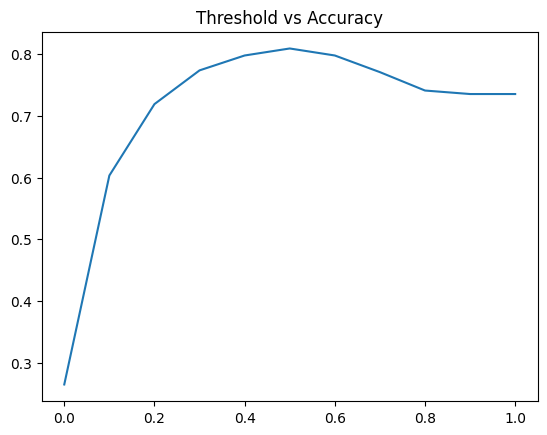

In [13]:
sns.lineplot(x=thresholds, y=accuracies)
plt.title('Threshold vs Accuracy')
plt.show()

In [14]:
from collections import Counter

In [15]:
# This line predicts all customers are no churning 
Counter(y_pred >= 1.0) 

Counter({False: 1409})

Dummy baseline

In [16]:
size_val = len(y_val)

In [17]:
baseline = np.repeat(False, size_val)

Checking the accuracy of the baseline predictions

In [18]:
print(f'The accuracy of the baseline is: {accuracy_score(y_val, baseline)*100:.2f} %')

The accuracy of the baseline is: 73.53 %


We have class imbalance, much more customers no churning

In [19]:
Counter(y_val)

Counter({0: 1036, 1: 373})

According to accuracy our model is slightly better than a dummy model that treats all the customers as non-churning. <br> Thus, we need other metrics of measuring the quality of the model

## Confusion table
* Confussion table: A table that concisely represents every possible outcome for our model's predictions
* Different types of erors and correct decisions

Calculating the confusion table with numpy

In [20]:
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

In [21]:
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

In [22]:
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

In [23]:
true_negative = (predict_no_churn & actual_no_churn).sum()
false_negative = (predict_no_churn & actual_churn).sum()

In [24]:
confusion_matrix = np.array(
    [[true_negative, false_positive],
    [false_negative, true_positive]])

In [25]:
confusion_matrix

array([[941,  95],
       [174, 199]])

Turning the absolute numbers into fractions (normalizing)

In [26]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.67, 0.07],
       [0.12, 0.14]])

#### Summary
* The performance of the model is not great it make quite a few errors when trying to identify users that will churn

##  Precision and recall
* Precision: Is the fraction of correctly predicted positive examples
* Recall: Is the fraction  of correctly classified positive examples among all positive examples

In [27]:
precision = true_positive / (true_positive + false_positive)

In [28]:
print(f'Precision of the model: {precision*100:.2f}%')

Precision of the model: 67.69%


In [29]:
recall = true_positive / (true_positive + false_negative)

In [30]:
print(f'Recall of the model: {recall*100:.2f}%')

Recall of the model: 53.35%


## ROC Curve
* It shows how well a model can seprate two classes, "churn" and "nor churn"
* We need two metrics for ROC curves: TPR (True Positive Rate) and FPR (False Positive Rate)
* False positive rate: The fraction of false positivies among all negative examples
* True positive rate: The fraction of true positives among all positive examples

#### TPR and FPR

In [31]:
fpr = false_positive / (false_positive + true_negative)
tpr = true_positive / (true_positive + false_negative)

In [32]:
print(f'FPR: {fpr*100:.2f}% \nTPR {tpr*100:.2f}%')

FPR: 9.17% 
TPR 53.35%


We still consider FPR and TPR metrics at only one threshold value, in our case, 0.5. To be able to use them for ROC curves, <br> we need to calculate these metrics for many different threshold values

* Evaluating a model at multiple threshold

In [33]:
scores = []

In [34]:
thresholds = np.linspace(0, 1, 101)

In [35]:
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred <= t) & (y_val == 1)).sum()
    tn = ((y_pred <= t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

In [36]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

In [37]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,373,1036,0,0
10,0.1,354,540,19,496
20,0.2,315,338,58,698
30,0.3,276,222,97,814
40,0.4,242,154,131,882
50,0.5,199,95,174,941
60,0.6,139,51,234,985
70,0.7,68,18,305,1018
80,0.8,10,2,363,1034
90,0.9,0,0,373,1036


In [38]:
df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'])

In [39]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,373,1036,0,0,1.000000,1.000000
10,0.1,354,540,19,496,0.949062,0.521236
20,0.2,315,338,58,698,0.844504,0.326255
30,0.3,276,222,97,814,0.739946,0.214286
40,0.4,242,154,131,882,0.648794,0.148649
50,0.5,199,95,174,941,0.533512,0.091699
60,0.6,139,51,234,985,0.372654,0.049228
70,0.7,68,18,305,1018,0.182306,0.017375
80,0.8,10,2,363,1034,0.026810,0.001931
90,0.9,0,0,373,1036,0.000000,0.000000


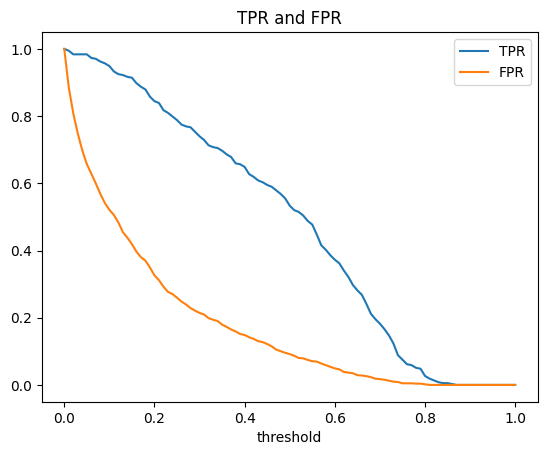

In [40]:
sns.lineplot(x=df_scores['threshold'], y=df_scores['tpr'])
sns.lineplot(x=df_scores['threshold'], y=df_scores['fpr']) 
plt.title('TPR and FPR')
plt.ylabel(None)
plt.legend(labels=['TPR', 'FPR'])
plt.show()

#### Random model
* A random model outputs a random score between 0 and 1, regardless of the input

In [41]:
np.random.seed(1)

In [42]:
y_rand = np.random.uniform(0, 1, size = len(y_val))

* Now we can simply pretend that y_rand contains the predictions of our "model"

In [43]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0,1,101)
    
    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred <= t) & (y_val == 1)).sum()
        tn = ((y_pred <= t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))
    
    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
    
    df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
    df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'])
    
    return df_scores

In [44]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [45]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,373,1036,0,0,1.000000,1.000000
10,0.1,336,934,37,102,0.900804,0.901544
20,0.2,295,834,78,202,0.790885,0.805019
30,0.3,261,739,112,297,0.699732,0.713320
40,0.4,218,643,155,393,0.584450,0.620656
50,0.5,182,538,191,498,0.487936,0.519305
60,0.6,146,424,227,612,0.391421,0.409266
70,0.7,112,311,261,725,0.300268,0.300193
80,0.8,78,206,295,830,0.209115,0.198842
90,0.9,39,102,334,934,0.104558,0.098456


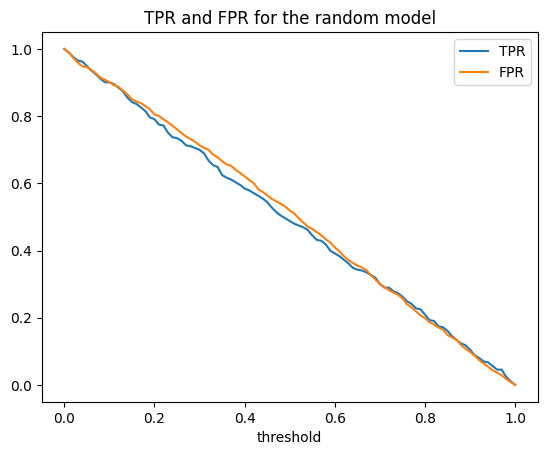

In [46]:
sns.lineplot(x=df_rand['threshold'], y=df_rand['tpr'])
sns.lineplot(x=df_rand['threshold'], y=df_rand['fpr']) 
plt.title('TPR and FPR for the random model')
plt.ylabel(None)
plt.legend(labels=['TPR', 'FPR'])
plt.show()

Both TPR and FPR curves go from 100% to 0%, almost following a straight line

#### The ideal model
* The ideal model always make correct decisions

In [47]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, len(y_ideal))
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

In [48]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,373,1036,0,1,1.000000,0.999036
10,0.1,373,895,0,141,1.000000,0.863900
20,0.2,373,754,0,282,1.000000,0.727799
30,0.3,373,613,0,423,1.000000,0.591699
40,0.4,373,472,0,564,1.000000,0.455598
50,0.5,373,332,0,705,1.000000,0.320154
60,0.6,373,191,0,845,1.000000,0.184363
70,0.7,373,50,0,986,1.000000,0.048263
80,0.8,282,0,91,1036,0.756032,0.000000
90,0.9,141,0,232,1036,0.378016,0.000000


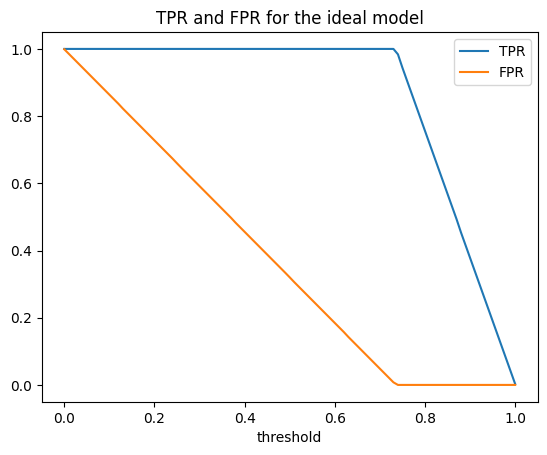

In [49]:
sns.lineplot(x=df_ideal['threshold'], y=df_ideal['tpr'])
sns.lineplot(x=df_ideal['threshold'], y=df_ideal['fpr']) 
plt.title('TPR and FPR for the ideal model')
plt.ylabel(None)
plt.legend(labels=['TPR', 'FPR'])
plt.show()

In [50]:
# Ideal situation
((y_pred_ideal >= 0.7352) == y_ideal).mean()

1.0

In [51]:
df_ideal.iloc[74].to_frame(name='ideal_situation')

,ideal_situation
threshold,0.740000
tp,367.000000
fp,0.000000
fn,6.000000
tn,1036.000000
tpr,0.983914
fpr,0.000000


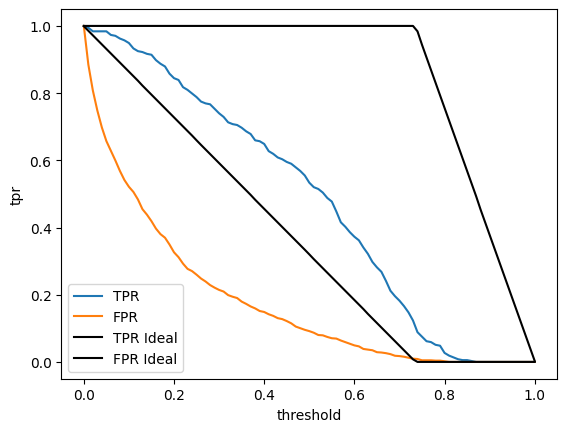

In [52]:
sns.lineplot(x=df_scores['threshold'], y=df_scores['tpr'])
sns.lineplot(x=df_scores['threshold'], y=df_scores['fpr']) 

#sns.lineplot(x=df_rand['threshold'], y=df_rand['tpr'])
#sns.lineplot(x=df_rand['threshold'], y=df_rand['fpr']) 

sns.lineplot(x=df_ideal['threshold'], y=df_ideal['tpr'], color='black')
sns.lineplot(x=df_ideal['threshold'], y=df_ideal['fpr'], color='black') 

plt.legend(labels=['TPR', 'FPR', 'TPR Ideal', 'FPR Ideal'])

plt.show()

#### Roc Curve

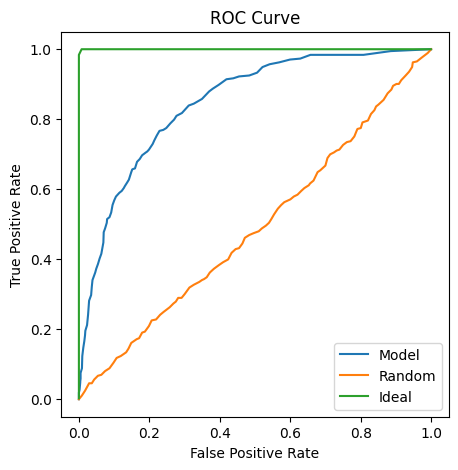

In [53]:
plt.figure(figsize=(5, 5))
plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')
plt.legend()
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Our model should always be somewhere between these two curves. We want our model to be as close to the ideal curve as possible and as far <br>as possible from the random curve

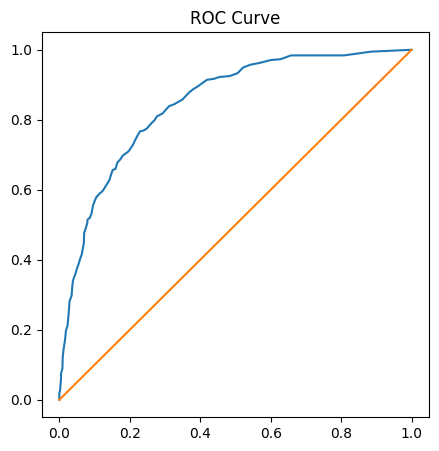

In [54]:
plt.figure(figsize=(5, 5))
plt.plot(df_scores.fpr, df_scores.tpr)
plt.plot([0,1], [0,1])
plt.title('ROC Curve')
plt.show()

* Plotting the ROC Curve with Scikit-learn

In [55]:
from sklearn.metrics import roc_curve

In [56]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

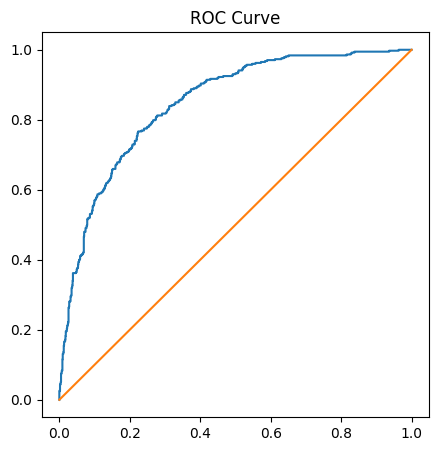

In [57]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])
plt.title('ROC Curve')
plt.show()          

## Area under the ROC curve (AUC)

In [58]:
from sklearn.metrics import auc

In [59]:
auc(df_scores.fpr, df_scores.tpr)

0.8462611404970654

In [60]:
#Using scikit-learn roc_curve function
auc(fpr, tpr)

0.8464254660635356

* If all we need is the AUC, we do not need to compute the ROC curve first, we can use roc_auc_score function

In [61]:
from sklearn.metrics import roc_auc_score

In [62]:
roc_auc_score(y_val, y_pred)

0.8464254660635356

* AUC: Is the probability that the score of a randomly selected churning customer is higher than the score of a randomly selected non-churning one

In [63]:
neg = y_pred[y_val == 0] # Select the score for all non-churning customers
pos = y_pred[y_val == 1] # Select the score for all churning customers
np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=10000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10000)

In [64]:
(pos[pos_choice] > neg[neg_choice]).mean()

0.8401

## Cross-Validation

* Function for training the model

In [65]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)
    
    return dv, model


* Function for Applying the model

In [66]:
def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred


* K-fold cross-validation 

In [67]:
from sklearn.model_selection import KFold

In [68]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [69]:
aucs = []

In [70]:
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

In [71]:
print(f'AUC mean: {np.mean(aucs):.3f} \nAUC std: ±{np.std(aucs):.3f}')

AUC mean: 0.843 
AUC std: ±0.014


* Our data shows that 68% of AUC were 0.844 ± 0.014 (1 standard deviation away from the mean)
* The smallest the std is, the more stable the model is 

#### Tuning the model: Selecting the best parameter C using cross-validation

* Function for training the model with the parameter C for controlling regularization

In [72]:
def train(df, y, C):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)
    
    return dv, model

In [73]:
nfolds = 5 
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

In [74]:
for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    print(f'C= {C}, AUC mean = {np.mean(aucs):.3f}, AUC std = {np.std(aucs):.3f}')

C= 0.001, AUC mean = 0.823, AUC std = 0.016
C= 0.01, AUC mean = 0.840, AUC std = 0.012
C= 0.1, AUC mean = 0.844, AUC std = 0.012
C= 0.5, AUC mean = 0.844, AUC std = 0.012
C= 1, AUC mean = 0.844, AUC std = 0.012
C= 10, AUC mean = 0.844, AUC std = 0.012


#### Training the model with the entire train and validation dataset and apply it to the test dataset

In [75]:
y_train =  df_train_full.churn.values

In [76]:
dv, model = train(df_train_full, y_train, C=0.1)
y_pred = predict(df_test, dv, model)

In [77]:
auc = roc_auc_score(y_test, y_pred)

In [78]:
print(f'AUC = {auc:.3f}') 

AUC = 0.852
